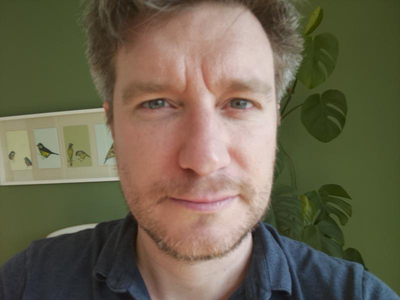

In [314]:
from PIL import Image, ImageFilter, ImageOps, ImageChops
import numpy as np

image = Image.open('selfie.jpg')
image = image.convert('RGB')
image

In [315]:
image.size

(400, 300)

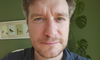

In [316]:
# Etch-a-Sketch screen is 5:3 ratio (e.g. (25) 125x75, (24) 120x72, (23) 115x69)

t_width, t_height = (100, 60)
c_width, c_height = image.size

wr, hr = t_width / c_width, t_height / c_height

# Scale the smallest dimension
ratio = wr if wr > hr else hr
target = int(c_width * ratio), int(c_height * ratio)
    
image_r = image.resize(target, Image.ANTIALIAS)

c_width, c_height = image_r.size

# Crop a rectangular region from this image. 
# The box is a 4-tuple defining the left, upper, right, and lower pixel coordinate.
hw, hh = c_width // 2, c_height // 2
x, y = t_width // 2, t_height // 2

image_r = image_r.crop((hw - x, hh -y, hw + x, hh + y))
image_r

In [317]:
image_r.size

(100, 60)

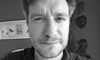

In [318]:
from PIL import ImageOps
gray = image_r.convert('L')
gray = ImageOps.autocontrast(gray)
gray

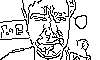

In [319]:
import cv2
import numpy as np

ocv = np.array(gray) 
threshold1 = 200
threshold2 = 50
edgec = cv2.Canny(ocv, threshold1, threshold2)
edgec = Image.fromarray(edgec)
edgec = ImageOps.invert(edgec)
edgec

Using the grayscale image we generate a 4-depth shader fill which can be used to add additional texture/depth to the image, and improve connectivity. See later for where it is applied.

In [320]:
fill_patterns = [
    np.array([[1]]),
    1-np.eye(16),    
    1-np.eye(8),    
    1-np.eye(4),    
]

In [321]:
def line_fill(img, mask_expand=0):
    data = np.array(img)   # "data" is a height x width x 4 numpy array
    output = data.copy()

    width, height = data.shape

    for n, pattern in enumerate(fill_patterns):

        p_width, p_height = pattern.shape

        fill_image = np.tile(pattern * 255, (width // p_width + 1, height // p_height + 1))
        fill_image = fill_image[:width, :height]  # Drop down to image dimensions, so we map straight through.
        mask = data == n
        output[mask] = fill_image[mask] 

    return Image.fromarray(output)

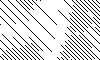

In [322]:
blur = ImageFilter.GaussianBlur(radius=2)
grayi = gray.filter(blur).convert('P', palette=Image.ADAPTIVE, colors=len(fill_patterns))
lined = line_fill(grayi, 4)
lined

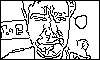

In [330]:
from PIL import ImageDraw
linede = edgec.copy()

def draw_border_box(img):
    draw = ImageDraw.Draw(img)
    draw.line(((0, 0), (t_width-1, 0)), fill=0, width=1)
    draw.line(((t_width-1, 0), (t_width-1, t_height-1)), fill=0, width=1)
    draw.line(((t_width-1, t_height-1), (0, t_height-1)), fill=0, width=1)
    draw.line(((0, t_height-1), (0, 0)), fill=0, width=1)
    
draw_border_box(linede)

linede

Uncomment the following line to add the shader fill to the image.

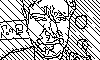

In [333]:
# linede = ImageChops.multiply(lined, edgec)


# The following line generates the shader filled image for info only, it does not replace linede.
ImageChops.multiply(lined, edgec)


The following block generates the graph from the image. We start from an empty undirected `networkx` graph and iterate over the entire image. By looking in 4 directions we can find all adjacent pixels as we scan. Adjacencies are added as edges (between two nodes, i.e. pixels), which in `networkx` automatically adds the nodes to the graph.

Because we depend on adjancencies single isolated pixels are dropped from the image.

In [332]:
import networkx as nx

data = np.array(linede).T #[::-1]
width, height = data.shape

# Build a network adjacency graph for black pixels in the image.
G = nx.Graph()

for x in range(0, width):
    for y in range(0, height):
        curr = (x, y)
        if data[curr] > 100: # white = 255
            continue
            
        if x < width - 1:
            right = (x + 1, y)
            if data[right] < 100:
                G.add_edge(curr, right)

            if y > 0:
                rup = (x + 1, y - 1)
                if data[rup] < 100:
                    G.add_edge(curr, rup)
                                
            if y < height - 1:
                rdown = (x + 1, y + 1)
                if data[rdown] < 100:
                    G.add_edge(curr, rdown)

        if y < height - 1:
            down  = (x, y + 1)
            if data[down] < 100:
                G.add_edge(curr, down)


In [334]:
G.number_of_nodes(), data.shape[0] * data.shape[1]

(1315, 6000)

In [290]:
def sign(x): return 1 if x >= 0 else -1

def cardinal(xd, yd):
    lr, ud = '', ''
    
    if xd == 0:
        return 'updown'
    
    elif yd == 0:
        return 'leftright'
    
    elif sign(xd) == sign(yd):
        return 'forwarddiag'

    elif sign(xd) != sign(yd):
        return 'backdiag'    

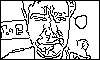

In [335]:
# Reconstitute image from nodes.
output = Image.new("L", data.shape, color=255)
for node in G.nodes():
    x, y = node
    output.putpixel(node, 0)
    
output

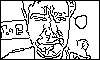

In [336]:
from PIL import Image, ImageDraw

output = Image.new("L", data.shape, color=255)
draw = ImageDraw.Draw(output)

# Reconstitute image, drawing edges.
for edge in G.edges():
    draw.line(edge, fill=0, width=0)
    
output

The following plots the image from the graph, but only the main (largest) graph is drawn in black. Other (unconnected) graphs are shown in red. These graphs must be connected for them to be drawable on the Etch-A-Sketch.

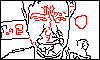

In [338]:
from networkx.algorithms.shortest_paths.generic import shortest_path
from networkx.algorithms.shortest_paths.unweighted import single_source_shortest_path
# Reconstitute image

Gc = G.copy()
data = np.array(linede).T

width, height = data.shape

output = Image.new("L", data.shape, color=255)
output = output.convert('RGB')
draw = ImageDraw.Draw(output)

# Reconstitute image, drawing edges.
for edge in G.edges():
    draw.line(edge, fill=(255,0,0), width=0)
        
# Get the largest network in our image (the one we're drawing hopefully)
giant = max(nx.connected_component_subgraphs(Gc), key=len)

# Reconstitute image, drawing edges.
for edge in giant.edges():
    draw.line(edge, fill=(0,0,0), width=0)

output

To link up the multiple subgraphs we iterate each graph's nodes in turn and find the shortest lines we can draw to connect the current graph with any other graph. We repeat this until there is only a single graph left.

An additional optimisation is done to increase the connectivity of the graph. Any gaps less than SHORT_LINK_LEN in distance (euclidean) are stored. If, after combining all graphs, the distance between these points is greater than SHORT_LINK_THRESHOLD we connect them by adding shortcuts across the gaps.

In [339]:
# Add diagonal edges to connect all subgraphs.
# Performed iteratively, connecting each subsequent graph to the the largest
import math

from networkx.algorithms.shortest_paths.generic import shortest_path_length

def sign(n):
    if n == 0: return 0
    return n / abs(n)
        

def euclidean_distance_straight(a, b):
    xd, yd = (a[0]-b[0]), (a[1]-b[1])
    if (
        abs(xd) == abs(yd) or xd == 0 or yd == 0

    ):
        return math.sqrt( (xd)**2 + (yd)**2 )

    
def graphs_node_iter(graphl):
    for g in graphl[::-1]:
        for node in g.nodes:
            yield node
    
SHORT_LINK_LEN = 5
SHORT_LINK_THRESHOLD = 25
    
Gc = G.copy()
graphs = sorted(nx.connected_component_subgraphs(Gc), key=len, reverse=True)
if len(graphs) > 1:

    # Ensure there is one (shortest) link between all graphs. Additionally add 
    # extra shortcut links below threshold length, to allow efficient drawing without back-tracking.
    giant, rest = graphs[:1], graphs[1:]
    links = []

    while rest:
        shortest = None

        for g in rest:

            # For each node in the graph, compare vs. all nodes in the giant-list. The
            # difference x,y must be 1:1 (diagonal), then find the shortest + link.
            for ng in graphs_node_iter(giant):
                for n0 in g.nodes:
                    d = euclidean_distance_straight(ng, n0)
                    if d:
                        link = d, g, ng, n0
                        # Find global short links
                        if (shortest is None or d < shortest[0]):
                            shortest = link
                            
                        if d < SHORT_LINK_LEN:
                            # Sub-graph link which is short, can be used to shortcut.
                            links.append(link)

        if shortest:
            d, g, ng, n0 = shortest
            Gc.add_edge(ng, n0, weight=d)
            # Move the linked graph to be part of the 'giant'.
            rest.remove(g)
            giant.append(g)

            
# Use detected short links to minimise the path lengths
for link in sorted(links, key=lambda x: x[0]):
    d, g, ng, n0 = link
    if shortest_path_length(Gc, ng, n0, weight='weight') >= SHORT_LINK_THRESHOLD:
        Gc.add_edge(ng, n0, weight=d)
            

We should now be able to draw the entire image using only the largest network (because there is only one).

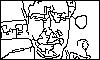

In [299]:
from PIL import Image, ImageDraw

output = Image.new("L", data.shape, color=255)
draw = ImageDraw.Draw(output)

# Get the largest network in our image (the one we're drawing hopefully)
giant = max(nx.connected_component_subgraphs(Gc), key=len)

# Reconstitute image, drawing edges of largest only.
for edge in giant.edges():
    draw.line(edge, fill=0, width=0)
    
output

The following plots the image as above, but highlights the added linker lines in red. Because these are long-distance links, they do not add any intermediate nodes. In practise this means that these lines are *optional* when plotting, and will only be used if needed.

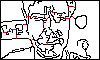

In [300]:
from networkx.algorithms.shortest_paths.generic import shortest_path
from networkx.algorithms.shortest_paths.unweighted import single_source_shortest_path
# Reconstitute image

data = np.array(linede).T

width, height = data.shape

output = Image.new("L", data.shape, color=255)
output = output.convert('RGB')
draw = ImageDraw.Draw(output)

# Reconstitute image, drawing edges.
for edge in Gc.edges:
    if Gc.edges[edge].get('linker'):
        draw.line(edge, fill=(0,255,0), width=0)
    elif Gc.edges[edge].get('weight'):
        draw.line(edge, fill=(255,0,0), width=0)
    else:
        draw.line(edge, fill=(0,0,0), width=0)

output

Finally we can simulate the plotting process.

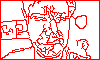

In [341]:
# Get the largest network in our image (the one we're drawing hopefully)
# TODO: Handle the case where 0,0 is not in the chosen graph.
rgiant = list(Gc.nodes)

n = 0
start = (0, 0)
color = (255,0,0)

def distance(n):
    # Note that start is modified by the loop.
    return math.sqrt( 
        (n[0]-start[0])**2 + 
        (n[1]-start[1])**2 
    )

degreeo = Image.new("L", data.shape, color=255)
degreeo = degreeo.convert('RGB')
draw = ImageDraw.Draw(degreeo)


def draw_path(draw, s, e, color):
    last_node = s
    path = shortest_path(Gc, s, e, weight='weight')
    
    for node in path[1:]:
        xi, yi = node
        
        draw.line([(last_node[0], last_node[1]), (xi, yi)], color)
        
        # Keep reference of where we've been for later.
        # Exponentially increase weight if we pass over the same point > 1
        Gc.edges[(node, last_node)]['weight'] = Gc.edges[(node, last_node)].get('weight', 1) * 2 # 10
        last_node = node 
    return path


while rgiant:

    n += 1    

    dnode = min(rgiant, key=distance)
    rgiant.remove(dnode)

    path = shortest_path(Gc, start, dnode, weight='weight')

    last_node = start

    # Traverse the path, yield all the steps required to get there.
    for node in path[1:]:
        # Yield this step to draw it (x & y can be > 1), may require multiple steps.
        draw.line([(last_node[0], last_node[1]), (node[0], node[1])], color)

        # Keep reference of where we've been for later, increase weight to discourage re-drawing.
        Gc.edges[(node, last_node)]['weight'] = Gc.edges[(node, last_node)].get('weight', 1) * 2
        last_node = node 

    # Chop away to avoid redundant paths.
    rgiant = set(rgiant) - set(path)

    # Update to our new position
    start = dnode    

degreeo